In [99]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

from dleps_predictor2_playground import DLEPS

## Note: protobuf error can be resolved by downgrading it v3.20.1

In [100]:
dleps_p = DLEPS()
dleps_p.model[0].summary()

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 277, 76)      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 269, 9)       6165        input_24[0][0]                   
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 261, 9)       738         conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv1D)                 (None, 251, 10)      1000        conv_2[0][0]                     
___________________________________________________________________________________________

In [101]:
import h5py

h5f = h5py.File('../../data/SMILE_train_demo2.h5', 'r')
smile_train = h5f['data'][:]
h5f2 = h5py.File('../../data/SMILE_test_demo2.h5', 'r')
smile_test = h5f2['data'][:]
h5f3 = h5py.File('../../data/appostasis_train_demo2.h5', 'r')
rna_train = h5f3['data'][:]
h5f4 = h5py.File('../../data/appostasis_test_demo2.h5', 'r')
rna_test = h5f4['data'][:]

print(rna_train.shape)
print(rna_test.shape)
print(smile_train.shape)
print(smile_test.shape)

(1026,)
(100,)
(1026, 277, 76)
(100, 277, 76)


In [102]:
his = dleps_p.train(smile_train, rna_train,(smile_test, rna_test), epochs=50,
                batch_size=32,
                shuffle=True,)

Train on 1026 samples, validate on 100 samples
Epoch 1/50
1026/1026 [==============================] - 3s 3ms/step - loss: 0.1569 - val_loss: 0.1538
Epoch 2/50
1026/1026 [==============================] - 1s 655us/step - loss: 0.1510 - val_loss: 0.1512
Epoch 3/50
1026/1026 [==============================] - 1s 742us/step - loss: 0.1500 - val_loss: 0.1497
Epoch 4/50
1026/1026 [==============================] - 1s 713us/step - loss: 0.1509 - val_loss: 0.1495
Epoch 5/50
1026/1026 [==============================] - 1s 804us/step - loss: 0.1478 - val_loss: 0.1480
Epoch 6/50
1026/1026 [==============================] - 1s 719us/step - loss: 0.1499 - val_loss: 0.1475
Epoch 7/50
1026/1026 [==============================] - 1s 735us/step - loss: 0.1474 - val_loss: 0.1465
Epoch 8/50
1026/1026 [==============================] - 1s 861us/step - loss: 0.1496 - val_loss: 0.1460
Epoch 9/50
1026/1026 [==============================] - 1s 787us/step - loss: 0.1444 - val_loss: 0.1453
Epoch 10/50
1026/10

[[1.         0.28272166]
 [0.28272166 1.        ]]
R2 Score: 0.055246086543561335
MSE Loss: 0.14042213999343564


Text(0, 0.5, 'predicted')

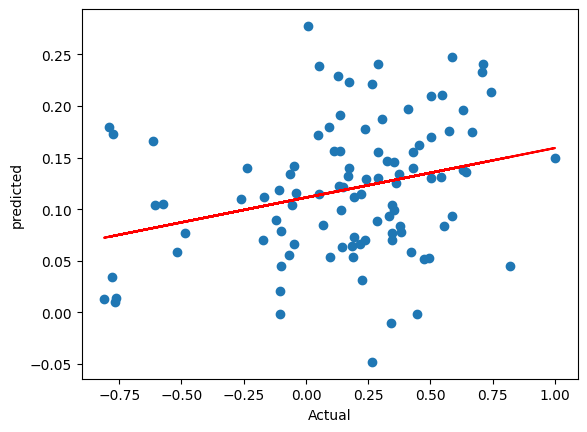

In [103]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
pred = dleps_p.model[0].predict(smile_test)
print(np.corrcoef(rna_test, pred.ravel()))
r2 = r2_score(rna_test, pred)
print(f'R2 Score: {r2}')
mse = mean_squared_error(rna_test, pred)
print(f'MSE Loss: {mse}')
# fig = plt.figure()
plt.scatter(rna_test, pred)
m, b = np.polyfit(rna_test, pred, 1)
plt.plot(rna_test, m * rna_test + b, 'r');
plt.xlabel('Actual')
plt.ylabel('predicted')
# fig.set_facecolor("white")

In [104]:
# Save model
from joblib import dump, load
# dump(dleps_p.model[0], 'model.joblib')

In [105]:
model = load('model.joblib')
model

In [106]:
h5f_zinc = h5py.File('../../data/SMILES_zinc_fda.h5', 'r')
zinc_test = h5f_zinc['data'][:]
zinc_pred = model.predict(zinc_test)
zinc_pred

array([[0.31242642],
       [0.4904589 ],
       [0.50625944],
       ...,
       [0.3635633 ],
       [0.37887007],
       [0.37069106]], dtype=float32)

In [107]:
# Merge test results column to the test dataset
import pandas as pd
zinc_fda_test = pd.read_csv('../../data/fda_zinc_final.csv')
zinc_fda_test.head()

,zinc_id,smiles
0,ZINC000001530427,C[C@@H]1O[C@@H]1P(=O)(O)O
1,ZINC000003807804,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1
2,ZINC000000120286,Nc1nc(N)c2nc(-c3ccccc3)c(N)nc2n1
3,ZINC000242548690,C[C@H]1O[C@@H](O[C@H]2[C@@H](O)C[C@H](O[C@H]3[...
4,ZINC000000008492,Oc1cccc2cccnc12


In [108]:
zinc_fda_test['results'] = zinc_pred
zinc_fda_test

,zinc_id,smiles,results
0,ZINC000001530427,C[C@@H]1O[C@@H]1P(=O)(O)O,0.312426
1,ZINC000003807804,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,0.490459
2,ZINC000000120286,Nc1nc(N)c2nc(-c3ccccc3)c(N)nc2n1,0.506259
3,ZINC000242548690,C[C@H]1O[C@@H](O[C@H]2[C@@H](O)C[C@H](O[C@H]3[...,0.341653
4,ZINC000000008492,Oc1cccc2cccnc12,0.444146
...,...,...,...
1607,ZINC000022010387,C[C@H]1[C@H](c2ccccc2)OCCN1C,0.387597
1608,ZINC000022448097,CCOc1ccc(C[C@@H](CN(CCN(CC(=O)O)CC(=O)O)CC(=O)...,0.362159
1609,ZINC000100370145,CC1(C)[C@H]2CC[C@@]1(CS(=O)(=O)O)C(=O)/C2=C/c1...,0.363563
1610,ZINC000059111167,[C-]#[N+]CC(C)(C)OC,0.378870


In [109]:
zinc_fda_test_sorted = zinc_fda_test.sort_values(by='results', ascending=False)
zinc_fda_test_sorted.head()

,zinc_id,smiles,results
889,ZINC000053045055,C[C@H](COc1ccccc1)N(CCCl)Cc1ccccc1,0.567667
1084,ZINC000000538283,CCC(=O)N(c1ccccc1)C1(C(=O)OC)CCN(CCC(=O)OC)CC1,0.566511
29,ZINC000000005560,C[C@H](C(=O)O)c1cccc(C(=O)c2ccccc2)c1,0.566280
1082,ZINC000012402836,CCN(CC)CCOc1ccc(/C(=C(\Cl)c2ccccc2)c2ccccc2)cc1,0.548898
215,ZINC000169621220,C[C@@H]1C/C=C/C=C/C=C/C=C/[C@H](O[C@H]2O[C@H](...,0.545231


In [110]:
zinc_fda_test_sorted.to_csv("../../data/zinc_fda_output_5.csv", index=False)

In [111]:
### End

In [112]:
# y_pred = dleps_p.model[0].predict(smile_train)
# rna_train = np.reshape(rna_train, y_pred.shape)
# print(rna_train.shape)
# print(y_pred.shape)
# corr = np.array([0.])
# corr=np.hstack((corr,np.corrcoef(rna_train[0],y_pred[0])[0, 1]))
# print(corr)


In [113]:
# import matplotlib.pyplot as plt
# import numpy as np
# %matplotlib inline

# y_pred = dleps_p.model[0].predict(smile_train)

# corr = np.array([0.])

# print(smile_train.shape)

# print(y_pred.shape)
# for i in range(smile_train.shape[0]):
    
#     corr=np.hstack((corr,np.corrcoef(rna_train[i],y_pred[i])[0, 1]))
# plt.hist(corr,50)
# plt.show()
# print(corr.mean())

In [114]:
# corr

In [115]:
# from scipy.stats import gaussian_kde

# def density(x,y):
#     xy = np.vstack([x,y])
#     return gaussian_kde(xy)(xy)

Training set

In [116]:
# n = 10  # how many digits we will display
# sam = 50
# plt.figure(figsize=(20, 6))

# with plt.style.context(['ggplot']):
#     plt.figure(figsize=(20, 6))
#     for i in range(10):
#         # display original
#         ax = plt.subplot(3, n, i + 1)

#         plt.scatter(y_pred[sam+i],rna_train[sam+i],c=density(y_pred[sam+i],rna_train[sam+i]),s=8,cmap=plt.get_cmap("coolwarm"))
#         ax = plt.subplot(3, n, i + 1*10+1)

#         plt.scatter(y_pred[sam+i+10],rna_train[sam+i+10],c=density(y_pred[sam+i+10],rna_train[sam+i+10]),s=8,cmap=plt.get_cmap("coolwarm"))
#         ax = plt.subplot(3, n, i + 1*20+1)

#         plt.scatter(y_pred[sam+i+20],rna_train[sam+i+20],c=density(y_pred[sam+i+20],rna_train[sam+i+20]),s=8,cmap=plt.get_cmap("coolwarm"))


# plt.tight_layout()
# #plt.savefig('../analysis_plot/Figures/Train_Samples3_density.svg', format='svg')

In [117]:
# plt.style.available

Analysis of Testing set

In [118]:
# y_pred2 = dleps_p.model[0].predict(smile_test)

# corr = np.array([0.])

# print(smile_test.shape)

# print(y_pred2.shape)
# for i in range(smile_test.shape[0]):
#     corr=np.hstack((corr,np.corrcoef(rna_test[i],y_pred2[i])[0, 1]))
# plt.hist(corr,50)
# plt.show()
# print(corr.mean())

Testing set

In [119]:
# n = 10  # how many digits we will display
# sam = 50
# with plt.style.context(['science','no-latex']):
#     plt.figure(figsize=(20, 6))
#     for i in range(10):
#         # display original
#         ax = plt.subplot(3, n, i + 1)

#         plt.scatter(y_pred2[sam+i],rna_test[sam+i],s=8,c=density(y_pred2[sam+i],rna_test[sam+i]),cmap="coolwarm")
#         ax = plt.subplot(3, n, i + 1*10+1)

#         plt.scatter(y_pred2[sam+i+10],rna_test[sam+i+10],c=density(y_pred2[sam+i+10],rna_test[sam+i+10]),s=8,cmap=plt.get_cmap("coolwarm"))
#         ax = plt.subplot(3, n, i + 1*20+1)

#         plt.scatter(y_pred2[sam+i+20],rna_test[sam+i+20],c=density(y_pred2[sam+i+20],rna_test[sam+i+20]),s=8,cmap=plt.get_cmap("coolwarm"))


# plt.tight_layout()
# #plt.savefig('../analysis_plot/Figures/Test_Samples3_density.svg', format='svg')